# Sentiment Analysis for Amazon Reviews

In [46]:
import string
import pandas as pd

import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report
from textblob import Word, TextBlob
from wordcloud import WordCloud

from warnings import filterwarnings
filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

nltk.download('stopwords')
nltk.download("punkt")
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hunkargencyildiz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/hunkargencyildiz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/hunkargencyildiz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/hunkargencyildiz/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Text Preprocessing

In [2]:
amazon_reviews = pd.read_excel("./datasets/amazon.xlsx")

In [3]:
amazon_reviews.head()

,Star,HelpFul,Title,Review
0,5,0,looks great,Happy with it
1,5,0,Pattern did not align between the two panels.,Good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,Product was fun for bedroom windows.<br />Imag...
3,5,0,Que se ven elegantes muy finas,Lo unico que me gustaria es que sean un poco ...
4,5,0,Wow great purchase,Great bang for the buck I can't believe the qu...


In [4]:
# Normalizing Case Folding
amazon_reviews['Review'] = amazon_reviews['Review'].str.lower()

In [5]:
amazon_reviews.head()

,Star,HelpFul,Title,Review
0,5,0,looks great,happy with it
1,5,0,Pattern did not align between the two panels.,good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,product was fun for bedroom windows.<br />imag...
3,5,0,Que se ven elegantes muy finas,lo unico que me gustaria es que sean un poco ...
4,5,0,Wow great purchase,great bang for the buck i can't believe the qu...


In [6]:
# Remove Punctuations
amazon_reviews['Review'] = amazon_reviews['Review'].fillna('')
amazon_reviews['Review'] = amazon_reviews['Review'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

In [7]:
amazon_reviews.head(3)

,Star,HelpFul,Title,Review
0,5,0,looks great,happy with it
1,5,0,Pattern did not align between the two panels.,good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,product was fun for bedroom windowsbr imagery ...


In [8]:
# Remove Numbers
amazon_reviews['Review'] = amazon_reviews['Review'].apply(lambda x: ''.join([i for i in x if not i.isdigit()]))

In [9]:
amazon_reviews.head(3)

,Star,HelpFul,Title,Review
0,5,0,looks great,happy with it
1,5,0,Pattern did not align between the two panels.,good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,product was fun for bedroom windowsbr imagery ...


In [10]:
# Remove Stop Words
sw = stopwords.words('english')
amazon_reviews['Review'] = amazon_reviews['Review'].apply(lambda x: ' '.join(x for x in str(x).split() if x not in sw))

In [11]:
amazon_reviews.head(3)

,Star,HelpFul,Title,Review
0,5,0,looks great,happy
1,5,0,Pattern did not align between the two panels.,good quality material however panels mismatched
2,5,0,Imagery is stretched. Still fun.,product fun bedroom windowsbr imagery bit stre...


In [12]:
# Remove Rare Words
temp_df = pd.Series(' '.join(amazon_reviews['Review']).split()).value_counts()[-1000:]

In [13]:
temp_df

paddys                             1
distracted                         1
hobby                              1
viewable                           1
gripe                              1
                                  ..
planner                            1
daysbrwouldn’t                     1
qualityðð»ðð»ðð»    1
believing                          1
studioliving                       1
Name: count, Length: 1000, dtype: int64

In [14]:
amazon_reviews['Review'] = amazon_reviews['Review'].apply(lambda x: " ".join(x for x in x.split() if x not in temp_df))

In [15]:
amazon_reviews.head(3)

,Star,HelpFul,Title,Review
0,5,0,looks great,happy
1,5,0,Pattern did not align between the two panels.,good quality material however panels mismatched
2,5,0,Imagery is stretched. Still fun.,product fun bedroom windowsbr imagery bit stre...


In [16]:
# Lemmatization
amazon_reviews['Review'] = amazon_reviews['Review'].apply(lambda x: ' '.join([Word(word).lemmatize() for word in x.split()]))

In [17]:
amazon_reviews.head(3)

,Star,HelpFul,Title,Review
0,5,0,looks great,happy
1,5,0,Pattern did not align between the two panels.,good quality material however panel mismatched
2,5,0,Imagery is stretched. Still fun.,product fun bedroom windowsbr imagery bit stre...


## Text Visualization

### Bar Plot

In [18]:
# Calculate tf
tf = amazon_reviews['Review'].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()

In [19]:
tf.columns = ["words", "tf"]

In [20]:
tf.sort_values("tf", ascending=False)

,words,tf
66,curtain,2587.00
42,look,1531.00
121,love,1452.00
104,room,1126.00
167,like,1053.00
...,...,...
1036,sheeronly,1.00
1028,preciosas,1.00
1022,breezy,1.00
1019,didit,1.00


In [21]:
tf[tf["tf"] > 500]

,words,tf
1,good,536.00
2,quality,888.00
3,material,565.00
29,great,920.00
35,color,787.00
42,look,1531.00
60,picture,719.00
63,nice,707.00
66,curtain,2587.00
92,light,606.00


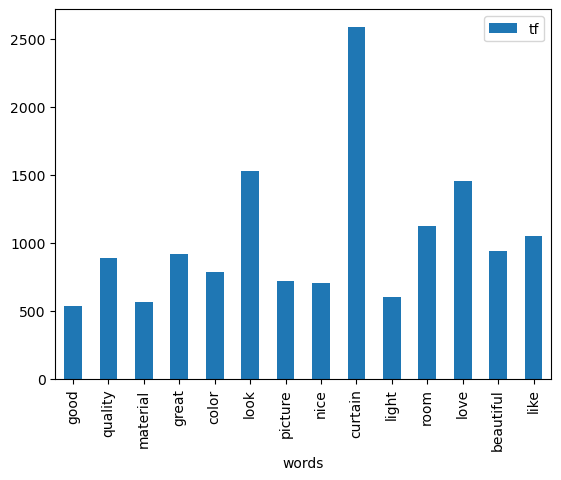

In [22]:
tf[tf["tf"] > 500].plot.bar(x="words", y="tf");

### WordCloud

In [23]:
text = " ".join(i for i in amazon_reviews.Review)

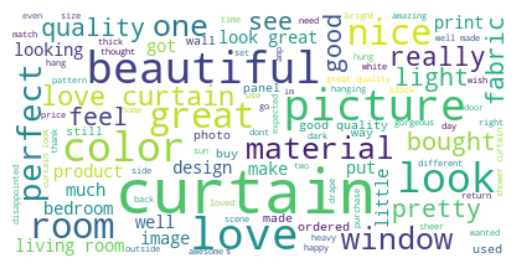

In [24]:
wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Sentiment Anlaysis

In [25]:
sia = SentimentIntensityAnalyzer()

In [26]:
amazon_reviews['Review'][0:10].apply(lambda x: sia.polarity_scores(x))

0    {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...
1    {'neg': 0.0, 'neu': 0.633, 'pos': 0.367, 'comp...
2    {'neg': 0.0, 'neu': 0.647, 'pos': 0.353, 'comp...
3    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
4    {'neg': 0.0, 'neu': 0.517, 'pos': 0.483, 'comp...
5    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
6    {'neg': 0.0, 'neu': 0.631, 'pos': 0.369, 'comp...
7    {'neg': 0.0, 'neu': 0.578, 'pos': 0.422, 'comp...
8    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
9    {'neg': 0.0, 'neu': 0.772, 'pos': 0.228, 'comp...
Name: Review, dtype: object

In [27]:
amazon_reviews['Review'][0:10].apply(lambda x: sia.polarity_scores(x)["compound"])

0   0.57
1   0.44
2   0.72
3   0.00
4   0.90
5   0.00
6   0.62
7   0.91
8   0.00
9   0.71
Name: Review, dtype: float64

## Feature Engineering

In [28]:
amazon_reviews["polarity_score"] = amazon_reviews['Review'].apply(lambda x: sia.polarity_scores(x)["compound"])

In [29]:
amazon_reviews.head(3)

,Star,HelpFul,Title,Review,polarity_score
0,5,0,looks great,happy,0.57
1,5,0,Pattern did not align between the two panels.,good quality material however panel mismatched,0.44
2,5,0,Imagery is stretched. Still fun.,product fun bedroom windowsbr imagery bit stre...,0.72


In [30]:
amazon_reviews["sentiment_label"] = amazon_reviews['Review'].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

In [31]:
amazon_reviews.head(3)

,Star,HelpFul,Title,Review,polarity_score,sentiment_label
0,5,0,looks great,happy,0.57,pos
1,5,0,Pattern did not align between the two panels.,good quality material however panel mismatched,0.44,pos
2,5,0,Imagery is stretched. Still fun.,product fun bedroom windowsbr imagery bit stre...,0.72,pos


In [32]:
amazon_reviews["sentiment_label"].value_counts()

sentiment_label
pos    4778
neg     833
Name: count, dtype: int64

In [34]:
amazon_reviews.groupby("sentiment_label")["Star"].mean()

sentiment_label
neg   3.40
pos   4.58
Name: Star, dtype: float64

## Split Train and Test

In [38]:
train_x, test_x, train_y, test_y = train_test_split(amazon_reviews["Review"],
                                                    amazon_reviews["sentiment_label"],
                                                    random_state=42)

In [41]:
# TF-IDF Word Level
tf_idf_word_vectorizer = TfidfVectorizer().fit(train_x)
x_train_tf_idf_word = tf_idf_word_vectorizer.transform(train_x)
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(test_x)

## Modelling (Logistic Regression)

In [44]:
log_model = LogisticRegression().fit(x_train_tf_idf_word, train_y)

In [47]:
y_pred = log_model.predict(x_test_tf_idf_word)

print(classification_report(y_pred, test_y))

cross_val_score(log_model, x_test_tf_idf_word, test_y, cv=5).mean()

              precision    recall  f1-score   support

         neg       0.31      0.93      0.46        74
         pos       1.00      0.88      0.94      1329

    accuracy                           0.89      1403
   macro avg       0.65      0.91      0.70      1403
weighted avg       0.96      0.89      0.91      1403



0.8510396542958821

In [48]:
# Recall: Recall is the ratio of correctly predicted positive observations to the total actual positives.
# Precision: Precision is the ratio of correctly predicted positive observations to the total predicted positives.
# F1-score: F1-score is the weighted average of precision and recall. It takes into account both false positives and false negatives.
# Accuracy: Accuracy is the ratio of correctly predicted observations to the total observations. 

In [50]:
random_review = pd.Series(amazon_reviews["Review"].sample(1).values)
yeni_yorum = CountVectorizer().fit(train_x).transform(random_review)
pred = log_model.predict(yeni_yorum)
print(f'Review:  {random_review[0]} \n Prediction: {pred}')

Review:  quality fair price expecting 
 Prediction: ['pos']


## Modelling (Random Forest)

In [51]:
rf_model = RandomForestClassifier().fit(x_train_tf_idf_word, train_y)
cross_val_score(rf_model, x_test_tf_idf_word, test_y, cv=5, n_jobs=-1).mean()

0.8973614641586172

In [53]:
random_review = pd.Series(amazon_reviews["Review"].sample(1).values)
yeni_yorum = CountVectorizer().fit(train_x).transform(random_review)
pred = rf_model.predict(yeni_yorum)
print(f'Review:  {random_review[0]} \n Prediction: {pred}')

Review:  nice thick curtain print crisp great addition son’s superhero room 
 Prediction: ['pos']


In [52]:
# Random Forest is better than Logistic Regression